## Import the Libraries

In [1]:
import os
import librosa
import librosa.display
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import time
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

C:\Users\Akash\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading the data

In [2]:
dir_list = os.listdir('dataset/')
dir_list.sort()

## Data Anlaysis
### 1. Plot the Spectogram

Text(0.5, 0, 'Seconds')

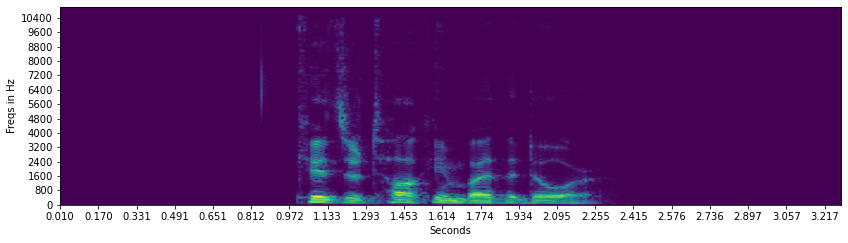

In [3]:
data, sample_rate = librosa.load('dataset/Actor_01/03-01-01-01-01-01-01.wav')
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

freqs, times, spectrogram = log_specgram(data, sample_rate)

fig = plt.figure(figsize=(14, 8))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

### 2. Plotting the MEL Power Spectrum

C:\Users\Akash\Anaconda3\lib\site-packages\librosa\display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Akash\Anaconda3\lib\site-packages\librosa\display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


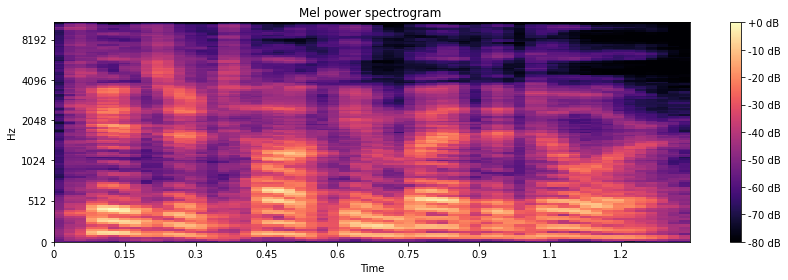

In [4]:
# Trim the silence voice
aa , bb = librosa.effects.trim(data, top_db=30)

S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### 3. Plotting the MFCC

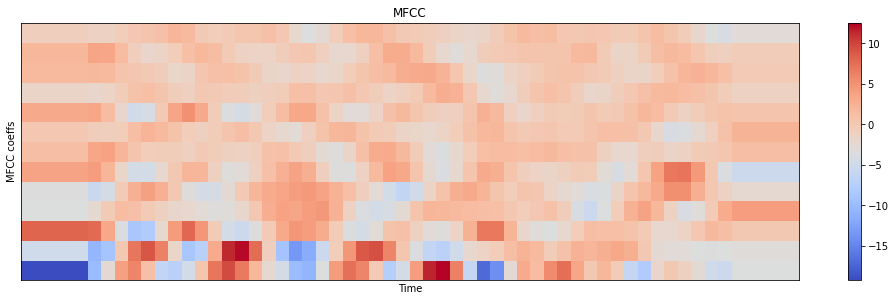

In [5]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

fig = plt.figure(figsize=(14,8))
ax3 = fig.add_subplot(211)

ax3.set_title('MFCC')
librosa.display.specshow(delta2_mfcc)

ax3.set_ylabel('MFCC coeffs')
ax3.set_xlabel('Time')
plt.colorbar()
plt.tight_layout()


# Load all files

In [6]:
path = 'dataset/'
lst = []
start_time = time.time()
for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
            X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            file = int(file[7:8]) - 1 
            arr = mfccs, file
            lst.append(arr)
      # If the file is not valid, skip it
        except ValueError:
            continue

print(" Total Loading time: %s seconds ---" % (time.time() - start_time))

 Total Loading time: 223.84005880355835 seconds ---


In [7]:
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((2392, 40), (2392,))

## Function to Plot Confusion Matrix 

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Function to Plot Accuracy Curve

In [9]:
classes=['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(1,1,1)
    width = 0.7 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=13,rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=15)
    plt.ylabel('Accuracy%', fontsize=15)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=15)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=15)

## Data Splitting

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

## Random Forest Classifier

In [11]:
rforest = RandomForestClassifier(n_estimators= 500, random_state= 2)
rforest.fit(X_train, y_train)
predictions = rforest.predict(X_test)

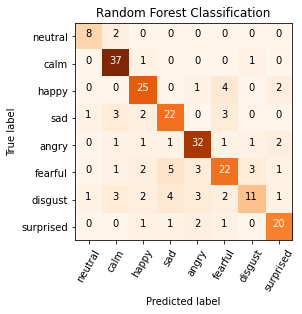

In [13]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, predictions)
classes=['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
plot_confusion_matrix(cnf_matrix,classes=classes,
                      title='Random Forest Classification',
                     cmap=plt.cm.Oranges)

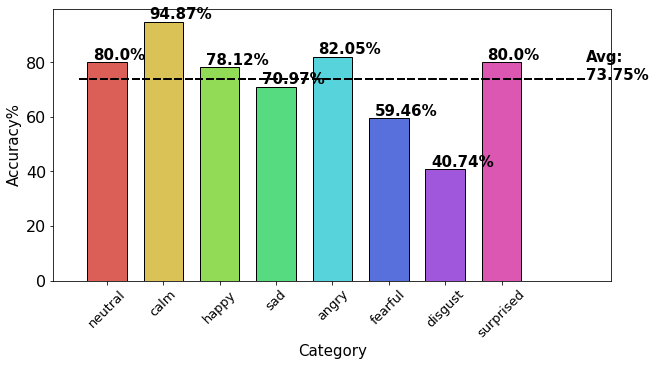

In [14]:
accuracy=accuracy_score(y_true=y_test, y_pred=predictions)
plot_acc_bar(cnf_matrix,total_acc=accuracy*100)

## K Nearest Neighbour

In [15]:
# Determining optimal value of k
x_axis = []
k_scores = []
for k in range(1,50, 1):
    x_axis.append(k)
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X_train, y_train,  scoring='accuracy')
    k_scores.append(scores.mean())
    
    #Printing values
    print("K = ",k)
    print("Scores : ")
    print(scores)
    print("Mean Score = ",scores.mean())
    print()

C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  1
Scores : 
[0.58333333 0.61227336 0.57902098]
Mean Score =  0.5915425578605495

K =  2
Scores : 
[0.50138889 0.51464435 0.47412587]
Mean Score =  0.49671970482639943



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  3
Scores : 
[0.49027778 0.50627615 0.47692308]
Mean Score =  0.4911590017761566

K =  4
Scores : 
[0.48194444 0.49790795 0.46713287]
Mean Score =  0.4823284204560356



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  5
Scores : 
[0.45555556 0.47559275 0.45594406]
Mean Score =  0.46236411968629537

K =  6
Scores : 
[0.45       0.46582985 0.45174825]
Mean Score =  0.45585936611041217



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  7
Scores : 
[0.45416667 0.46304045 0.42377622]
Mean Score =  0.44699444558231166

K =  8
Scores : 
[0.44861111 0.45188285 0.42377622]
Mean Score =  0.4414233933585398



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  9
Scores : 
[0.44166667 0.44630404 0.41678322]
Mean Score =  0.4349179760267627

K =  10
Scores : 
[0.45416667 0.44769874 0.4027972 ]
Mean Score =  0.4348875380779147



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  11
Scores : 
[0.45416667 0.44909344 0.38881119]
Mean Score =  0.4306904334624

K =  12
Scores : 
[0.45416667 0.45467225 0.38881119]
Mean Score =  0.43255003364836003



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  13
Scores : 
[0.4375     0.44351464 0.3972028 ]
Mean Score =  0.42607248051808716

K =  14
Scores : 
[0.43472222 0.43654114 0.39160839]
Mean Score =  0.4209572524949094



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  15
Scores : 
[0.42083333 0.42956764 0.38321678]
Mean Score =  0.411205919835627

K =  16
Scores : 
[0.42222222 0.41980474 0.39020979]
Mean Score =  0.4107455848041622



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  17
Scores : 
[0.43194444 0.43235704 0.38041958]
Mean Score =  0.4149070226999097

K =  18
Scores : 
[0.41944444 0.41841004 0.37482517]
Mean Score =  0.40422655370354116



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  19
Scores : 
[0.41944444 0.41143654 0.37622378]
Mean Score =  0.40236825393729153

K =  20
Scores : 
[0.43055556 0.41841004 0.38041958]
Mean Score =  0.40979505927204674



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  21
Scores : 
[0.42361111 0.41422594 0.37902098]
Mean Score =  0.40561934385156145

K =  22
Scores : 
[0.4125     0.42259414 0.36923077]
Mean Score =  0.4014416371633945



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  23
Scores : 
[0.425      0.41701534 0.35804196]
Mean Score =  0.4000190999144974

K = 

C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


 24
Scores : 
[0.40138889 0.42398884 0.35664336]
Mean Score =  0.39400702931037657

K =  25
Scores : 
[0.40555556 0.41143654 0.35664336]
Mean Score =  0.39121181778085545



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  26
Scores : 
[0.40694444 0.40864714 0.36223776]
Mean Score =  0.39260978251564027

K =  27
Scores : 
[0.40833333 0.41422594 0.34965035]
Mean Score =  0.3907365414687591



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  28
Scores : 
[0.40416667 0.42119944 0.34965035]
Mean Score =  0.39167215281232015

K =  29
Scores : 
[0.3875     0.40864714 0.34545455]
Mean Score =  0.3805338954397532



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  30
Scores : 
[0.37361111 0.40725244 0.35104895]
Mean Score =  0.3773041676284354

K =  31
Scores : 
[0.37222222 0.40167364 0.35524476]
Mean Score =  0.3763802058781138



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  32
Scores : 
[0.38194444 0.41004184 0.34825175]
Mean Score =  0.38007934456679227

K =  33
Scores : 
[0.36805556 0.40027894 0.35524476]
Mean Score =  0.3745264169427349



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  34
Scores : 
[0.38194444 0.39609484 0.36083916]
Mean Score =  0.37962614829769636

K =  35
Scores : 
[0.38194444 0.38912134 0.35664336]
Mean Score =  0.37590304666664504



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  36
Scores : 
[0.38333333 0.38493724 0.35664336]
Mean Score =  0.37497130949013796



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  37
Scores : 
[0.37638889 0.38493724 0.34825175]
Mean Score =  0.36985929187812033

K =  38
Scores : 
[0.38055556 0.36959554 0.35524476]
Mean Score =  0.3684652825866215



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  39
Scores : 
[0.38333333 0.36680614 0.35664336]
Mean Score =  0.36892760888576787

K = 

C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


 40
Scores : 
[0.37777778 0.36820084 0.35664336]
Mean Score =  0.36754065708040606

K =  41
Scores : 
[0.38472222 0.38493724 0.35944056]
Mean Score =  0.37636667338550184



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  42
Scores : 
[0.3875     0.38075314 0.35804196]
Mean Score =  0.37543169870575727

K =  43
Scores : 
[0.38333333 0.37656904 0.35664336]
Mean Score =  0.3721819092111979



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  44
Scores : 
[0.37638889 0.38912134 0.35664336]
Mean Score =  0.37405119481479315

K =  45
Scores : 
[0.37361111 0.39748954 0.36503497]
Mean Score =  0.37871187196501



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  46
Scores : 
[0.37361111 0.39609484 0.35664336]
Mean Score =  0.3754497691213172

K =  47
Scores : 
[0.375      0.40167364 0.36083916]
Mean Score =  0.3791709336688416



C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


K =  48
Scores : 
[0.3875     0.39888424 0.36643357]
Mean Score =  0.38427260210733016

K =  49
Scores : 
[0.38611111 0.38075314 0.36783217]
Mean Score =  0.37823213900619757



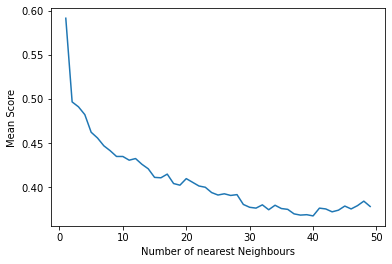

In [16]:
plt.plot(x_axis, k_scores)
plt.xlabel('Number of nearest Neighbours')
plt.ylabel('Mean Score')
plt.show()

In [17]:
KNN = KNeighborsClassifier(n_neighbors=1, p=1)
KNN.fit(X_train, y_train)
predictions = KNN.predict(X_test)

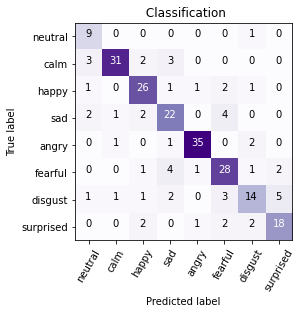

In [18]:
cnf_matrix = confusion_matrix(y_test, predictions)
classes=['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
plot_confusion_matrix(cnf_matrix,classes=classes,
                      title=' Classification',
                     cmap=plt.cm.Purples)

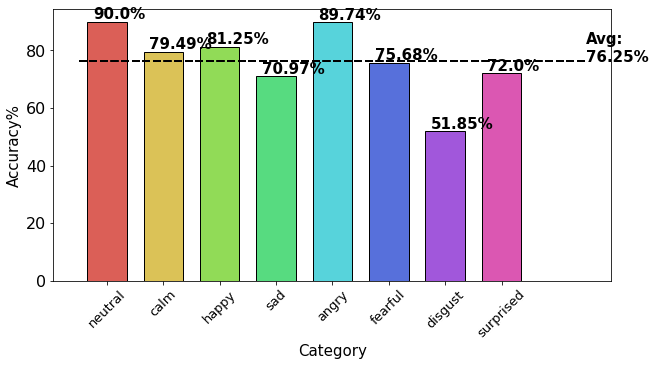

In [19]:
accuracy=accuracy_score(y_true=y_test, y_pred=predictions)
plot_acc_bar(cnf_matrix,total_acc=accuracy*100)

In [20]:
MLP = MLPClassifier(alpha=0.01, batch_size=230, random_state=4,activation='logistic', hidden_layer_sizes=(150,), max_iter=600)
MLP.fit(X_train, y_train)
predictions = MLP.predict(X_test)

C:\Users\Akash\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


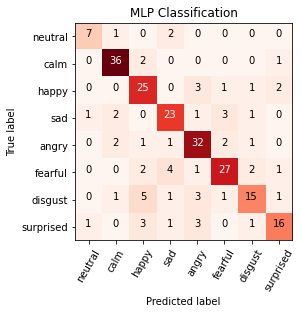

In [21]:
cnf_matrix = confusion_matrix(y_test, predictions)
classes=['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
plot_confusion_matrix(cnf_matrix,classes=classes,
                      title='MLP Classification',
                     cmap=plt.cm.Reds)

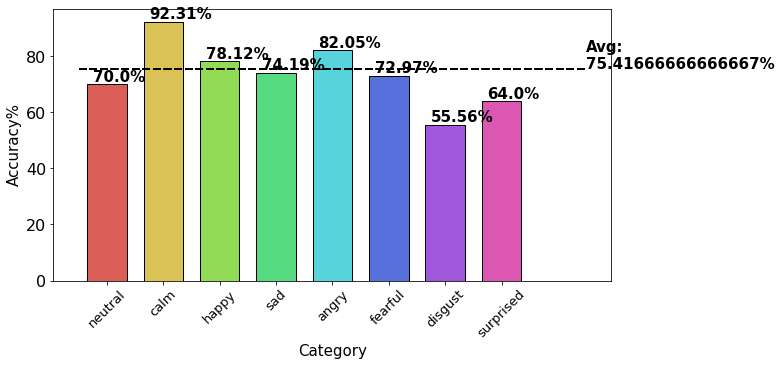

In [22]:
accuracy=accuracy_score(y_true=y_test, y_pred=predictions)
plot_acc_bar(cnf_matrix,total_acc=accuracy*100)